In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

from energy_centre import EnergyCentre

In [3]:
timestep = '0.5H'
timestamp_from = '2019-01-01 00:00:00'
timestamp_to = '2019-12-31 23:30:00'
ScotBord = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)

In [4]:
ScotBord.get_data_scottish_borders()

In [5]:
ScotBord.apply_constraint_discount()

In [6]:
# add heat and elec buses
ScotBord.add_bus('heat')
ScotBord.add_bus('elec')
ScotBord.network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
heat,1.0,,0.0,0.0,heat,None,1.0,0.0,inf,PQ,
elec,1.0,,0.0,0.0,elec,None,1.0,0.0,inf,PQ,


In [7]:
# add heat and elec demands
ScotBord.add_heat_demand()
ScotBord.add_elec_demand()
ScotBord.network.loads_t.p_set

,Heat_Demand,Elec_Demand
snapshot,,
2019-01-01 00:00:00,0.4304,0.1610
2019-01-01 00:30:00,0.4232,0.1720
2019-01-01 01:00:00,0.4160,0.1830
2019-01-01 01:30:00,0.4813,0.1915
2019-01-01 02:00:00,0.5466,0.2000
...,...,...
2019-12-31 21:30:00,1.0326,0.4235
2019-12-31 22:00:00,0.9532,0.4240
2019-12-31 22:30:00,0.8482,0.4140


In [8]:
# add grid connection as elec generator
ScotBord.add_grid_connection()
ScotBord.network.generators_t.marginal_cost

,Grid
snapshot,
2019-01-01 00:00:00,65.75
2019-01-01 00:30:00,73.50
2019-01-01 01:00:00,68.25
2019-01-01 01:30:00,61.75
2019-01-01 02:00:00,52.50
...,...
2019-12-31 21:30:00,34.55
2019-12-31 22:00:00,38.55
2019-12-31 22:30:00,34.35


In [9]:
# add heat pump as link
ScotBord.add_heat_pump()
# add resistive heater as link
ScotBord.add_resistive_heater()
ScotBord.network.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
Heat_Pump,elec,heat,,,1.0,0,inf,1000000.0,False,0.0,inf,0.0,0.0,1.0,0.0,0.000,0.0,1.0,0.0
Resistive_Heater,elec,heat,,,1.0,0,inf,1000000.0,False,0.0,inf,0.0,0.0,1.0,0.0,0.001,0.0,1.0,0.0


In [10]:
# add storage
ScotBord.add_short_term_store()
ScotBord.add_long_term_store()

In [11]:
# run LOPF
ScotBord.network.lopf(ScotBord.network.snapshots,
                    solver_name="gurobi",
                #   pyomo=False,
                #   keep_shadowprices=True,
                    )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x192721_copy
  Lower bound: 260267.9015406433
  Upper bound: 260267.9015406433
  Number of objectives: 1
  Number of constraints: 315361
  Number of variables: 192721
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 192721
  Number of nonzeros: 578159
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [12]:
ScotBord.network.links_t.p0

,Heat_Pump,Resistive_Heater,heat_sts_charge,heat_sts_to_demand,heat_lts_charge,heat_lts_to_sts
snapshot,,,,,,
2019-01-01 00:00:00,0.886311,0.0,2.940000,0.935775,0.17,0.00
2019-01-01 00:30:00,0.000000,0.0,0.836800,1.260000,0.17,0.00
2019-01-01 01:00:00,0.000000,0.0,0.844000,1.260000,0.17,0.00
2019-01-01 01:30:00,0.000000,0.0,0.778700,1.260000,0.17,0.00
2019-01-01 02:00:00,0.654990,0.0,0.980160,0.000000,0.17,0.00
...,...,...,...,...,...,...
2019-12-31 21:30:00,0.768619,0.0,0.613984,0.000000,0.00,0.17
2019-12-31 22:00:00,0.000000,0.0,0.000000,0.953200,0.00,0.17
2019-12-31 22:30:00,0.846292,0.0,0.978122,0.000000,0.00,0.17


In [13]:
ScotBord.network.links_t.p1

,Heat_Pump,Resistive_Heater,heat_sts_charge,heat_sts_to_demand,heat_lts_charge,heat_lts_to_sts
snapshot,,,,,,
2019-01-01 00:00:00,-2.434625,-0.0,-2.940000,-0.935775,-0.17,-0.00
2019-01-01 00:30:00,-0.000000,-0.0,-0.836800,-1.260000,-0.17,-0.00
2019-01-01 01:00:00,-0.000000,-0.0,-0.844000,-1.260000,-0.17,-0.00
2019-01-01 01:30:00,-0.000000,-0.0,-0.778700,-1.260000,-0.17,-0.00
2019-01-01 02:00:00,-1.526760,-0.0,-0.980160,-0.000000,-0.17,-0.00
...,...,...,...,...,...,...
2019-12-31 21:30:00,-1.646584,-0.0,-0.613984,-0.000000,-0.00,-0.17
2019-12-31 22:00:00,-0.000000,-0.0,-0.000000,-0.953200,-0.00,-0.17
2019-12-31 22:30:00,-1.826322,-0.0,-0.978122,-0.000000,-0.00,-0.17


In [14]:
ScotBord.network.generators_t.p

,Grid
snapshot,
2019-01-01 00:00:00,1.047311
2019-01-01 00:30:00,0.172000
2019-01-01 01:00:00,0.183000
2019-01-01 01:30:00,0.191500
2019-01-01 02:00:00,0.854990
...,...
2019-12-31 21:30:00,1.192119
2019-12-31 22:00:00,0.424000
2019-12-31 22:30:00,1.260292


In [15]:
ScotBord.network.loads_t.p

,Heat_Demand,Elec_Demand
snapshot,,
2019-01-01 00:00:00,0.4304,0.1610
2019-01-01 00:30:00,0.4232,0.1720
2019-01-01 01:00:00,0.4160,0.1830
2019-01-01 01:30:00,0.4813,0.1915
2019-01-01 02:00:00,0.5466,0.2000
...,...,...
2019-12-31 21:30:00,1.0326,0.4235
2019-12-31 22:00:00,0.9532,0.4240
2019-12-31 22:30:00,0.8482,0.4140


In [16]:
ScotBord.network.generators_t.marginal_cost

,Grid
snapshot,
2019-01-01 00:00:00,65.75
2019-01-01 00:30:00,73.50
2019-01-01 01:00:00,68.25
2019-01-01 01:30:00,61.75
2019-01-01 02:00:00,52.50
...,...
2019-12-31 21:30:00,34.55
2019-12-31 22:00:00,38.55
2019-12-31 22:30:00,34.35


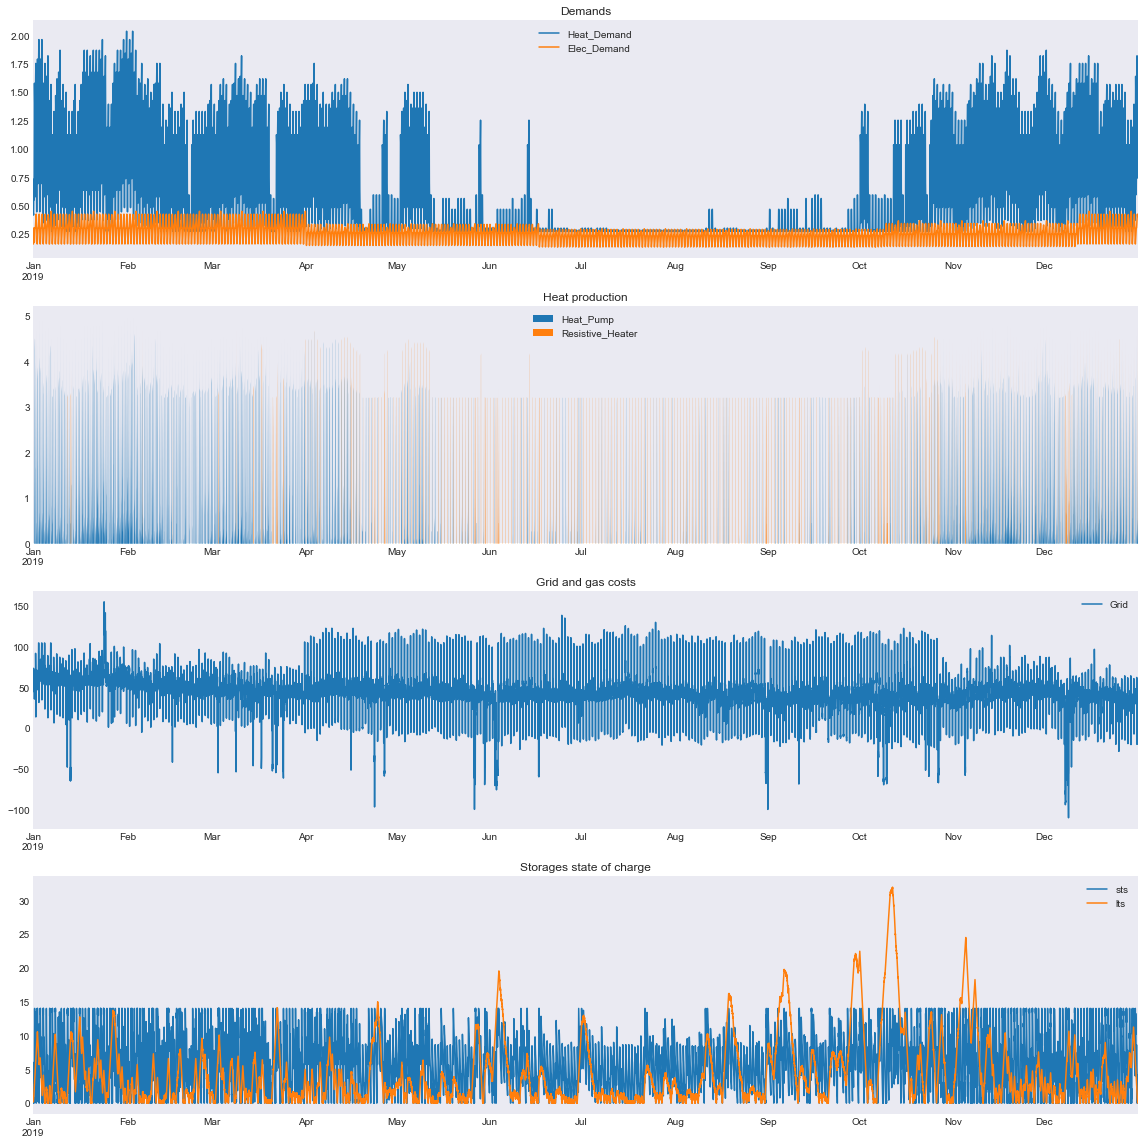

In [17]:
ScotBord.network.generators_t.p['Heat_Pump'] = ScotBord.network.links_t.p1.Heat_Pump * -1
ScotBord.network.generators_t.p['Resistive_Heater'] = ScotBord.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

ScotBord.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
ScotBord.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
ScotBord.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
ScotBord.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Heat production'}>

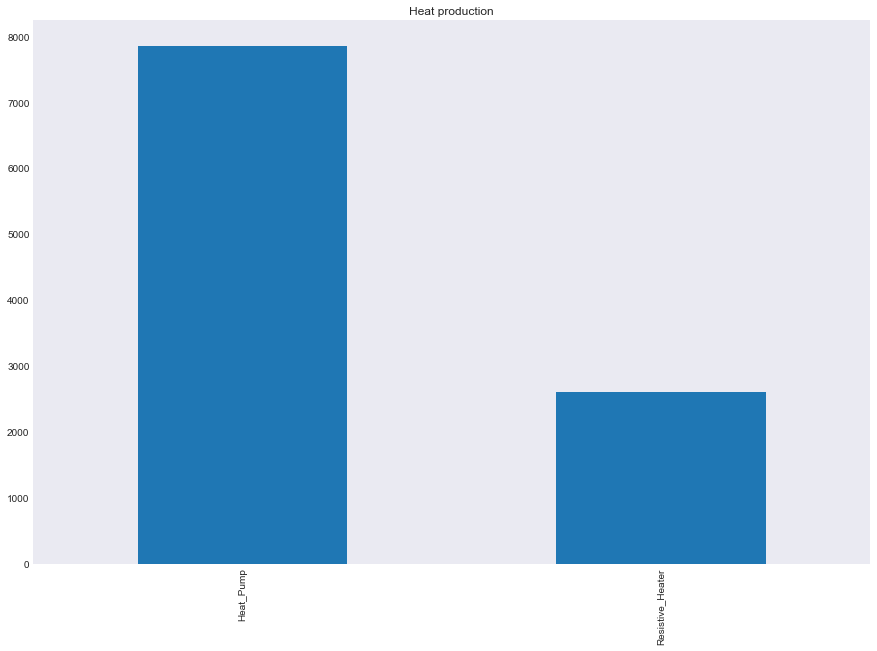

In [18]:
ScotBord.network.generators_t.p.rename_axis('').drop(columns=['Grid']).sum().plot.bar(figsize=(15,10), title='Heat production')

<AxesSubplot:title={'center':'Half-hourly Carbon Emissions (kgCO2)'}>

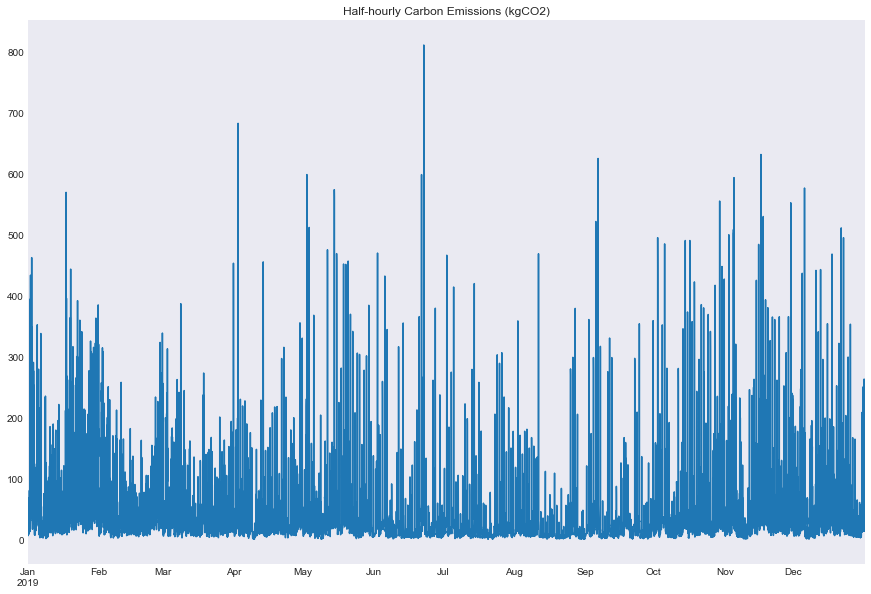

In [19]:
ScotBord.carbon_calculator(ScotBord.network.generators_t.p.Grid)
ScotBord.carbon_emissions.plot(figsize=(15,10), title='Half-hourly Carbon Emissions (kgCO2)')

Total carbon emissions kgCO2

In [20]:
ScotBord.carbon_emissions.sum().round(2)

612680.45

Total costs £

In [21]:
ScotBord.network.objective

260267.9015406433

In [24]:
ScotBord.network.objective_constant


-0.0